# Trust Region Policy Optimization (TRPO)

Uptil now you should be familiar with Policy Methods like [REINFORCE](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Policy%20Networks%20(REINFORCE)/policy_networks.ipynb), [REINFORCE w/ Baseline](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/REINFORCE%20with%20Baseline/reinforce_with_baseline.ipynb), [Actor Critic](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Vanilla%20Actor%20Critic/actor_critic.ipynb), and hopefully [GAE](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Generalized%20Advantage%20Estimate/generalized_advantage_estimation.ipynb) as these are the prereqs. You hopefully also know what [Taylor Series Expansion](https://en.wikipedia.org/wiki/Taylor_series) and [Lagrange Multipliers](https://en.wikipedia.org/wiki/Lagrange_multiplier) are! This is fairly advanced and would't recommend this to a beginner, its best if you are comfortable with all the previous ideas first as I wont be talking about the basics here! But lets review a little of the main ideas:

## Policy Optimization Recap

Our loss function that we derived for our Policy Gradient was:

$$\nabla_\theta J(\theta) \propto E_{\pi} \left[\Psi\nabla_\theta \ln\pi_\theta(a|s)\right]$$

Where $\Psi$ can be all sorts of stuff, like Monte Carlo returns, TD(0) estimates, Advantage, and others! The main goal of our Policy Gradient method is to learn a policy $\pi(a|s)$ that can tell us the best action to take at a state. This is different from the previous value-based methods where were weren't directly optimizing the Policy, but rather optimizing the Value function $Q(s,a)$ and then deriving the policy from that! Here is a great figure from [GAE](https://arxiv.org/abs/1506.02438) showing this!

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Generalized%20Advantage%20Estimate/src/gae_paper_fig.png?raw=true" alt="drawing" width="600"/>

### Problem

Unfortunately, if our entire decision making is dependent on this policy model $\pi$, this can lead to poor training stability. As our model updates, it can have large fluctuations in what it thinks the ideal action should be, so we need a way to reign this in. Therefore, what we need is something like a regularization technique, that avoids parameter updates that change the policy too much. 

### Computing Distance Btwn Policies

Lets say we have two policies, $\pi_1$ and $\pi_2$. Both of these are a probability distribution over the actions I could take at a particular state. Do we know of a metric to compute the distance between two distributions? Of course! KL-Divergence!

The Kullback-Leibler (KL) Divergence is a measure of how much one probability distribution differs from another. 

For discrete action spaces, the KL-Divergence is:
$$D_{\text{KL}}(\pi_1 \| \pi_2) = \sum_{a} \pi_1(a|s) \log \left( \frac{\pi_1(a|s)}{\pi_2(a|s)} \right)$$

Therefore our goal is to ensure that whenever we train our policy, that don't allow the KL divergence between the new and old policy to exceed some threshold! 

#### Limitations

The TRPO improves the stability of training by introducing a constraint on the policy update with KL-Divergence. Therefore, the TRPO policy update is done by taking the largest step possible to improve performance, while simultaneouly satisfying its constraint. When training our Policy Gradient models, we can sometimes see a collapse in performance, as small changes in the parameters can lead to large changes in probailities. 

Therefore the update rule for TRPO looks like:

$$\theta_{k+1} = arg\max_\theta L(\theta_k,\theta)$$
$$\text{s.t. } D_{KL}(\theta||\theta_k) < \delta$$

Where $L(\theta_k, \theta)$ is known as a surrogate advantage. Here is the equation first:

$$L(\theta_k, \theta) = E_{s,a\sim\pi_{\theta_k}}\left[\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)}A_{\pi_{\theta_k}}(s,a)\right]$$

First, our advantage function $A_{\pi_{\theta_k}}(s,a)$ is the measure of how much better an action a is than the average value of the state when evaluating policy $\pi_{\theta_k}$ (just like before!) What we are interested in is evaluating the new policy $\pi_\theta$, and to do this we can use something kown as Importance Sampling. This is the same Importance Sampling we saw when building our [Prioritized Experience Replay](https://github.com/priyammaz/PyTorch-Adventures/blob/8546809993cd6fd11e152f0e23d2969fc5516906/PyTorch%20for%20Reinforcement%20Learning/Intro%20to%20Deep%20Reinforcement%20Learning/Prioritized%20Experience%20Replay/prioritized_experience_replay.ipynb#L53)! 

But incase you don't remember, the main idea is that sometimes we want to convert densities between distributions. In our case $A_{\pi_{\theta_k}}(s,a)$ was taken from the distribution $\pi_{\theta_k}$, but we want to estimate $\pi_\theta$, Therefore, what if we scaled our $A_{\pi_{\theta_k}}(s,a)$, dividing by our $\pi_{\theta_k}$ and multiplying by $\pi_\theta$. This is effectively converting our advantage results from our original distribution to our new one!

When we grab samples by interacting with the environment, this is done with the current policy $\pi_{\theta_k}$. But we want to estimate the advantage function for the new policy we want to update do $\pi_\theta$. Therefore Importance sampling reweights our sampled from the old policy to approximate the distribution under the new one!

##### Problem: Intractability
The issue here is that this loss function is intractable. It requires an expectation computation over things that would be annoying to compute every iteration, so we need something simpler way to do this. And to do this, we use first order approximations (from Taylor Series) to represent our functions (hoping) it is sufficient!

#### Objective Approximation

Lets do the first order taylor expansion of our objective function:

$$L(\theta_k, \theta) = E_{s,a\sim\pi_{\theta_k}}\left[\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)}A_{\pi_{\theta_k}}(s,a)\right]$$

If we do a Taylor series (centering $\theta$ around $\theta_k$), we wil get:

$$L(\theta_k,\theta) \approx L(\theta_k, \theta_k) + \nabla_\theta L(\theta_k, \theta)(\theta - \theta_k)$$

And $L(\theta_k, \theta_k)$ is just a constant, so we can ignore it in our optimization leaving us with:

$$L(\theta_k, \theta) \approx \nabla_\theta L(\theta_k, \theta)(\theta - \theta_k)$$

and you will see this often written as:

$$L(\theta_k, \theta) \approx g^T(\theta - \theta_k)$$

We could have had more terms in our approximation (higher order taylor series) but these end up being very small numbers, and because our goal is to maximize this objective, the gradient direction dominates all other approximations

#### KL Approximation

The KL Approximation is where it gets trickier. Lets do an expansion of the KL Divergence with taylor series:

$$D_{KL}(\theta||\theta_k) \approx D_{KL}(\theta_k||\theta_k)+ \nabla_\theta D_{KL}(\theta||\theta_k)|_{\theta=\theta_k}(\theta - \theta_k) + \frac{1}{2}\nabla_\theta^2 D_{KL}(\theta||\theta_k)|_{\theta=\theta_k}(\theta - \theta_k)^2$$

Lets check each term individually:

- $D_{KL}(\theta_k||\theta_k)$: The KL Divergence between a distribution and itself is just 0
- $\nabla_\theta D_{KL}(\theta||\theta_k)|_{\theta=\theta_k}(\theta - \theta_k)$: The minimum kl divergence is at $\theta_k$, so the derivative of our KL divergence evaluated at $\theta_k$ would just be 0

Therefore we are just left with:

$$D_{KL}(\theta||\theta_k) \approx \frac{1}{2}\nabla_\theta^2 D_{KL}(\theta||\theta_k)|_{\theta=\theta_k}(\theta - \theta_k)^2$$

and our first non-zero term is a second order differentiation. That sounds very expensive...

Lets write its vector notation (replacing our second derivative with its corresponding Hessian) 

$$D_{KL}(\theta||\theta_k) \approx \frac{1}{2}(\theta - \theta_k)^T H (\theta - \theta_k)$$

So our final optimization problem now becomes:

$$\theta_{k+1} = arg\max_\theta g^T(\theta - \theta_k)$$
$$\text{s.t. } \frac{1}{2}(\theta - \theta_k)^T H (\theta - \theta_k) < \delta$$

### How Do You Optimize This?

This is where the math gets very challenging, so I leave out nitty-gritty details (Minorize-Maximize algorithm). Lets go through some of the main ideas of the setup so you know where most things are coming from!

#### Step 1: Lagrangian Dual Form

This is a constrained optimization problem (technically KKT because its an inequality constraint). To do that we can solve for the Dual problem like so:

Using lagrangian multipliers we can write:

$$L(\theta, \lambda) = g^T(\theta - \theta_k)  - \lambda \left( \frac{1}{2}(\theta - \theta_k)^T H (\theta - \theta_k) \right)$$

We can now take the derivative w.r.t $\theta$

$$\nabla_\theta L = g - \lambda H (\theta - \theta_k) = 0$$
$$(\theta - \theta_k) = \frac{1}{\lambda}H^{-1}g$$

and we have our relation now that our ideal $\theta^*$ is:
$$\theta^*= \theta_k + \frac{1}{\lambda}H^{-1}g$$


Lets plug that into our original expression for our constraint:

$$\frac{1}{2}(\theta - \theta_k)^T H (\theta - \theta_k)$$
$$\frac{1}{2}\left(\frac{1}{\lambda}H^{-1}g\right)^T H \left(\frac{1}{\lambda}H^{-1}g \right)$$

Because our Hessian Matrix looks like:

$$
H(f) = 
\begin{bmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
\frac{\partial^2 f}{\partial x_2 \partial x_1} & \frac{\partial^2 f}{\partial x_2^2} & \cdots & \frac{\partial^2 f}{\partial x_2 \partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} & \frac{\partial^2 f}{\partial x_n \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}
$$

It is a symmetric matrix. This means the we can use the property that for symmetric matricies $H = H^T$ and $H^{-1} = \left({H^{-1}}\right)^T$.

Thefefore we can rewrite:

$$\frac{1}{2}\left(\frac{1}{\lambda}H^{-1}g\right)^T H \left(\frac{1}{\lambda}H^{-1}g \right)$$
$$= \frac{1}{2\lambda^2}\left(g^TH^{-1}\right) H \left(H^{-1}g \right)$$
$$= \frac{1}{2\lambda^2}g^TH^{-1}g $$

So we have our expression for our threshold that our secord order approximation of the KL-Divergence is:
$$\delta = \frac{1}{2\lambda^2}g^TH^{-1}g $$

What we want is it in terms of our Lagrandian coefficient $\lambda$ so lets just rewrite it as:

So we have our expression for our threshold that our secord order approximation of the KL-Divergence is:
$$\lambda = \sqrt{\frac{g^TH^{-1}g}{2\delta}}$$

So from our update relationship before:

$$\theta^*= \theta_k + \frac{1}{\lambda}H^{-1}g$$

We can rewrite it as:
$$\theta^* = \theta_{k} + \sqrt{\frac{2\delta}{g^TH^{-1}g}}H^{-1}g$$

But a new problem has emerged. Not only do we need a second derivative, we now need its inverse too...

#### Step 2: Conjugate Gradients

To avoid having to take an actual matrix inverse we can use a trick. What if we wrote:

$$x \approx H^{-1}g$$

In which case, we could write:

$$Hx \approx g$$

This looks like the usual problem we want to solve, $Ax=b$. We can use a variety of methods to solve this, but the one selected was the Conjugate Gradient Method, most likely for its efficiency and speed to solve even complex systems. 

The main reason for this is that it uses orthogonal search directions. As its optimizing, it avoids zig-zagging over the search space so its not undoing movement from one step in another. 

<img src="src/cg.png" alt="drawing" width="600"/>

You can learn all about Conjugate Gradients in this great intro called [Conjugate Gradients Without the Agonizing Pain](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf). I wont be deriving the more minute details of where this method comes from or any of its convergence properties as its out of the scope of what we are trying to do today, but feel free to learn more! Lets just analyze the procedure:

##### Reformatting the Problem

Our goal is to solve $Ax=b$ which we can rewrite as $Ax-b=0$. $A$ must be a symmetric positive-definite matrix, but we are dealing with a Hessian Matrix $H$ so its no problem. Now when it comes to solving systems, each method has a trick, because we could obviously have done the inverse, but that is too expensive. The first one used by Conjugate Gradients is rewriting the formula as minimizing the quadratic function:

$$f(x) = \frac{1}{2}x^TAx -b^Tx$$

This is equivalent, because if you take the derivative and set to 0:

$$\nabla f(x) = Ax-b = 0$$

Which is what we want anyway!

##### Setting up the Initial Guess

Our goal is to solve for $x$, and this is an iterative method so we need a guess.

Let $x_0$ be our initial guess, and we typically initialize as a 0 vector. This means that we can write the following:

$$\text{Residual } r_0 = b - Ax_0 = - \nabla f(x_0)$$

We can compute our residual which also happens to be the negative gradient in our setup. Therefore this is the direction of steepest descent (exactly like gradient descent methods)

Therefore our initial search direction to optimize will be in this direction:

$$p_0 = r_0$$

##### Choose a Direction

Conjuage Gradient makes use of a method called A-Orthogonal or A-Conjugate directions. For two vectors to be orthogonal they follow the property:

$$x_i^Tx_j = 0$$

But what we really want aren't directions that are orthonal to each other, but rather orthogonal to the vector space projected by $A$ that you are in. 

This can be written as:

$$x_i^TAx_j = 0$$

<img src="src/a_ortho.png" alt="drawing" width="600"/>

Notice how our vectors in the transformed space (left images) arent technically orthogonal to each other. But if you undid the transformed space back to a regular XY plane, then they are! Thats basically what it means to be A-Orthogonal.
##### Computing the Step Size

We have the direction of steepest descent, but we definitely dont want to go all the way. We want to scale our direction by some step size as follows:

$$x_{k+1} = x_k + \alpha_kp_k$$

To do this we can use:

$$\alpha_k = \frac{r_k^T r_k}{p_k^TAp_k}$$

We are computing the ratio of our square residuals to our A-Orthogonal directions. The close the denominator is to 0, the more "A-Orthogonal" it is, so we are confident in taking a larger step. And the further away the denominator is from 0, the less "A-Orthogonal" it is, so we are less confident in taking that step.

##### Update Estimate and Residual

Now that we have our $\alpha$ we can actually update $x$:

$$x_{k+1} = x_k + \alpha_kp_k$$

We can also update our residual. To do this we need to quickly show a recursive relation in our residuals as follows:

if: 

$$x_{k+1} = x_k + \alpha_kp_k$$

Then we can also write:

$$Ax_{k+1} = Ax_k + \alpha_kAp_k$$
$$b - Ax_{k+1} = b - \left(Ax_k + \alpha_kAp_k\right)$$
$$r_{k+1} = r_k - \alpha_kAp_k$$

##### Update our Direction

Last step is to update our search direction for the next iteration. In regular gradient descent methods, we would just set $p_{k+1} = r_{k+1}$, therefore always moving in the direction with the most negative gradient. This would lead to the problem though that we would over or under estimate and zigzag along our descent, making it inefficient. 

Our goal is therefore to make sure that $p_{k+1}$ is A-Conjugage to $p_k$ so each search direction is A-Conjuate to each other. Lets say we do a very similar update function where:

$$p_{k+1} = r_{k+1} + \beta_kp_k$$

The goal is to add some new components to our gradient descent search direction $r$ to maintain our A-Orthogonal property. Then starting with:

$$p_{k+1}^TAp_k = 0$$

We can rewrite it as:

$$(r_{k+1} + \beta_kp_k)^TAp_k = 0$$
$$r_{k+1}^TAp_k + \beta_kp_k^TAp_k = 0$$

and solving for our scaling constant $\beta$ we get:

$$\beta = -\frac{r_{k+1}^TAp_k}{p_k^TAp_k}$$

Although this is correct, it isn't used in practice as it requires a matrix/vector multiplication. Instead we use:

$$\beta_k = \frac{r_{k+1}^Tr_{k+1}}{r_{k}^Tr_{k}}$$

Lets see breifly where this comes from! Remember our residual update rule we already made:

$$r_{k+1} = r_k - \alpha_kAp_k$$

This means we can write:

$$Ap_k = \frac{1}{\alpha}(r_k - r_{k+1})$$

Lets multiply both sides by $r_{k+1}^T$:

$$r_{k+1}^TAp_k = \frac{1}{\alpha}r_{k+1}^T(r_k - r_{k+1})$$

Lets substitute this into our form for $\beta$:

$$\beta = -\frac{r_{k+1}^T(r_k - r_{k+1})}{\alpha p_k^TAp_k}$$
$$= -\frac{r_{k+1}^Tr_k - r_{k+1}^Tr_{k+1}}{\alpha p_k^TAp_k}$$

And here is the first imporant part! Due to the assumption of orthogonality of our directions, the residuals must also be orthogonal (there is a whole proof for this that I am glossing over!) 

But if we just assume that as true, then $r_{k+1}^Tr_k = 0$ as they are orthgonal to each other, therefore we can write:

$$= \frac{r_{k+1}^Tr_{k+1}}{\alpha p_k^TAp_k}$$

Now lets wrangle that denominator. Remember earlier we found that:

$$\alpha_k = \frac{r_k^T r_k}{p_k^TAp_k}$$

Looks like that $p_k^TAp_k$ is right there ready for us to use again!

$$p_k^TAp_k = \frac{r_k^T r_k}{\alpha_k}$$

So lets plug it in!

$$\frac{r_{k+1}^Tr_{k+1}}{\alpha p_k^TAp_k}$$
$$= \frac{r_{k+1}^Tr_{k+1}}{\alpha \frac{r_k^T r_k}{\alpha_k}}$$
$$= \frac{r_{k+1}^Tr_{k+1}}{r_k^T r_k}$$

And there we go! We have our final form, and we can go ahead and put the whole procedue here now:

<img src="src/cg_proc.png" alt="drawing" width="400"/>

#### Step 3: Line Search

We now have our parameter update directions! The Conjugate Gradient method tells me the best direction I can move. We have our update formula here:

$$\theta^*= \theta_k + \frac{1}{\lambda}H^{-1}g$$

And we just used conjugate gradients to compute $H^{-1}g$ without actually taking that inverse. The next step is to actually update our $\theta$. This is where the "Trust Region" portion of our implementation shows up. 

<img src="src/trust_region.png" alt="drawing" width="600"/>

[Image Source](https://medium.com/trust-region-methods/temp-blog-1b51189594a)

A trust region can be thought of like a region of confidence. The main idea is that, when iterating in our optimization, we often dont know what to expect due to the complex optimization space. So what if we did a local estimation of the gradient using a simpler model? We could use a linear or quadratic model (typically a second order taylor approximation) to take a guesstimate of what the topology of that area looks like and hope that its enough. We can then use this simple model to define an area of trust.

<img src="src/local_approx.png" alt="drawing" width="600"/>

The trust is determined by the performance of the previous iteration. If we take a step determined by our simple model, and this step does indeed descend (or ascend depending on what you want) your objective function, then you have high trust that your approximation is a good estimator of the gradients of your objective function, atleast in that region. This means you can take larger steps!

On the other hand, if you use your approximation and see that your steps are not improving your optimization of the objective function, we will decrease the trust radius as we are less confident. 

This can almost be thought of like an adaptive learning rate, when we you only take large steps when you know you can expect to get a good approximation. Therefore, we can do the following:

Lets say we have a local quadratic approximation of our objective function $f(x)$ at some point $x_k$. We can write this as:

$$f(x_k) \approx f(x_k) + \nabla f(x_k)(x-x_k) + \frac{1}{2}\nabla^2 f(x_k)(x-x_k)^2$$

And to just match a more common (vectorized) notation that says the same thing for multiple dimensions we will write this as:

$$m_k(s) = f(x_k) + \nabla f(x_k)^Ts + \frac{1}{2} s^THs$$

where:

- $s$ is our step size $x-x_k$
- $H$ is our second derivative Hessian

A trust region is one where our step size is within some limit:

$$||s|| \leq \delta_k$$

We can then minimize our sub-problem on the simplified quadratic model. Essentially we will do:

$$\min_p m_k(s) \text{ such that } ||s|| \leq \delta_k$$

Now to solve this subproblem (another constrained optimization) there are a few methods you can try (cauchy point, dogleg, etc...) but these are out of the scope of our exploration here, and **THEY ARENT ACTUALLY USED!!**

The thing is that, these methods have a few problems for what we are doing:

- Another constrained optimization? We are already doing conjugate gradients in one place, this would be too expensive especially on high dimensional data
- Our "Hessian" isn't a true hessian, its just an approximation and so it doesn't exactly work with these methods

So there is only one other way to do it! Try a bunch of step sizes! Ideally we can take the full step we calculate and then we can check if we are violating our threshold for $\delta$. If it does, try a smaller scale. And keep scaling until you have a step small enough to work. This way we take the largest step we can without breaking any assumption

##### Evaluating the Trust Region

Once we have our ideal step size that we have determined, we can compute our Trust Region:

$$\rho_k = \frac{f(x_k) - f(x_k + s_k)}{m_k(0) - m_k(s_k)}$$

- If $\rho_k = 1$, that means the change in the quadratic approximation is identical to the change in the objective function. This is High Trust, because our simplified model can well reproduce the more complex function we are trying to represent.

Selecting $\rho$ is a hyperparameter, of what ratio are we willing to accept. We then try progressively smaller step sizes until something meets this ratio! As you can imagine, the smaller the step size, the easier it is for our simple model to approximate complex objective functions.  

### Lets Implement It!

This was a lot of small details, but its time to start putting it together. For this implementation, I referenced a few very helpful repos [pytorch-trpo](https://github.com/ikostrikov/pytorch-trpo/tree/master) and [TRPO-PyTorch](https://github.com/alirezakazemipour/TRPO-PyTorch) as well as this Medium article by [Vladyslav Yazykov](https://medium.com/@vladogim97/trpo-minimal-pytorch-implementation-859e46c4232e) so they get all the credit for the code! One difference is that in their code, they work with continuous action spaces (we will get there in the future). Today we will work with discrete action spaces, so a few changes there. Think of this as an annotated walkthrough!

Also, this implementation is pretty different as we wont really be using a lot of PyTorch's functionality! The only thing we need from PyTorch is AutoGrad

#### Implement the Model

This is the same Actor-Critic setup we had before!

In [1]:
import argparse
import gymnasium as gym
import numpy as np
import scipy.optimize
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple
from functools import partial

class ActorPolicyNetwork(nn.Module):
    def __init__(self,
                 input_state_features=8, 
                 num_actions=4,
                 hidden_features=128):
        
        super(ActorPolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        pi = F.softmax(self.fc3(x), dim=-1)
        return pi

class CriticValueNetwork(nn.Module):
    def __init__(self, input_state_features=8, hidden_features=128):
        super(CriticValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_state_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, 1)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

### Memory 

Lets create a quick Replay buffer to store and return experience tuples!

In [2]:
class Memory:
    def __init__(self):
        self.states = []
        self.actions = []
        self.dones = []
        self.next_states = []
        self.rewards = []

    def store(self, state, action, done, next_state, reward):
        self.states.append(state)
        self.actions.append(action)
        self.dones.append(0 if done else 1)
        self.next_states.append(next_state)
        self.rewards.append(reward)

    def reset(self):
        self.states = []
        self.actions = []
        self.dones = []
        self.next_states = []
        self.rewards = []
        
    def sample(self):
        return np.array(self.states, dtype=np.float32), \
               np.array(self.actions), \
               np.array(self.dones, dtype=np.float32), \
               np.array(self.next_states, dtype=np.float32), \
               np.array(self.rewards, dtype=np.float32)

    def __len__(self):
        return len(self.states)

### Some Utility Functions for Weights

If you remember, we wont be using PyTorch optimizers. This means we need to manually handle the weights and update them ourselves!

These are some helper functions to:

- Grab parameters from model and flatten to a single vector of parameters
- Grab a vector of parameters and copy back into model
- Grab gradients of all parameters and flatten into a single vector

In [3]:
def get_flat_params_from(model):
    """
    Copy all parameters from model store as vector
    """
    return torch.cat([param.data.flatten() for param in model.parameters()])

def set_flat_params_to(model, flat_params):
    """
    Take vector of parameters and copy back into model
    """

    ### Starting index in vector is 0
    prev_ind = 0
    for param in model.parameters():

        ### Check how many parameters are in this weight matrix ###
        flat_size = int(np.prod(list(param.size())))

        ### Copy in that portion ###
        param.data.copy_(flat_params[prev_ind:prev_ind + flat_size].reshape(param.size()))
        
        ### Move starting index ###
        prev_ind += flat_size

def get_flat_grad_from(net):
    """
    Copy all gradients from parameters and store
    """
    return torch.cat([param.grad.flatten() for param in net.parameters()])

### Implement Conjugate Gradients

This is basically a direct rewrite of the procedure we saw earlier! Now we have a bit of an issue. Our conjugate gradient is to solve:

$$Hx=b$$

without explicitly taking the inverse. But we dont have our Hessian yet! For now don't worry about that, we will write a method after to actually compute the Hessian multiplied by a vector. For now, we will pass in this method as ```Fvp```. Remember that we will be using:

$$\alpha_k = \frac{r_k^T r_k}{p_k^TAp_k}$$

So the $Ap_k$ will be reused, and $A$ in our case is $H$ the Hessian. So the method we write later:

```python
def Fvp(v):
    ...
```

will multiply our vector $p_k$ by our Hessian Approximation



In [4]:
def conjugate_gradients(Avp, 
                        b, 
                        n_iters=10, 
                        residual_tol=1e-10):

    """
    This is an implementation of the Conjuage Gradient Method. In our case,
    Avp is a method that returns the estimate of the hessian
    """

    ### Initialize x as Zeros (same shape as B as A is square) ###
    x = torch.zeros(b.size())

    ### r = b - Ax ###
    r = b.clone()

    ### p = r ###
    p = b.clone()

    ### We will need r^T * r repeatedly, lets do it ahead of time ###
    rdotr = torch.dot(r, r)

    ### For Num Steps ###
    for i in range(n_iters):

        ### Compute Ap ###
        _Avp = Avp(p)

        ### Compute Alpha ###
        alpha = rdotr / torch.dot(p, _Avp)

        ### Update X ###
        x += alpha * p

        ### Update r ###
        r -= alpha * _Avp

        ### Compute new r^T * r
        new_rdotr = torch.dot(r, r)

        ### Compute Beta ###
        beta = new_rdotr / rdotr

        ### Update p ###
        p = r + beta * p

        ### Set for next iteration ###
        rdotr = new_rdotr

        ### Check Tolerance ###
        if rdotr < residual_tol:
            break
            
    return x

### Line Search

Next up is how we actually determine the step size (to stay inside our Trust Region). We basically will try a bunch of constants in descending order, and keep the largest step that meets our conditions. To do this, we need to pass in our method to compute the loss! We haven't written the ```get_loss``` method yet, we will in a bit. But we will pass this method in so we can compute the loss for different step sizes. This will provide us the largest perturbation we can make to our model parameters, while remaining inside our trust region (expressed by the ```accept_ratio```)

In [5]:
def linesearch(model, 
               get_loss_method, 
               prev_params, 
               fullstep,
               expected_improve_rate, 
               max_backtracks=10, 
               accept_ratio=0.1):

    """
    model: Our policy model
    get_loss_method: function to compute the loss (policy grad loss)
    prev_params: Parameters we pass in and will test for updates
    fullstep: The largest step we can take determined by conjugate gradient
    expected_improve_rate: We expect the full update to be the loss_grad * step_dir (we compute this later)
    max_backtracks: How many ratios do you want to try?
    accept_ratio: Minimum accepted ratio (of actual to expected improvement)
    """

    ### Get our Current Loss ###
    loss = get_loss_method().detach()

    ### Try a Bunch of Steps ###
    ### with different ratios in descending order ###
    for stepfrac in 0.5 ** np.arange(max_backtracks):

        ### Update X by adding our scaled step ###
        x_new = prev_params + stepfrac * fullstep

        ### Copy new weights to model ###
        set_flat_params_to(model, x_new)

        ### Compute Loss Again ###
        new_loss = get_loss_method().detach()

        ### Compute Actual Improvement (we want to descent so we hope new is less than old) ###
        actual_improve = loss - new_loss

        ### Compute How Much We Expected to Improve ###
        expected_improve = expected_improve_rate * stepfrac

        ### Compute ratio ###
        ratio = actual_improve / expected_improve 

        ### See if we want to accept and end search ###
        if ratio.item() > accept_ratio and actual_improve.item() > 0:
            return True, x_new

    return False, prev_params

### TRPO Step 

This is the most important part of the implementation! We need to do a full step of TRPO. This includes a few things, but the main one is to compute the Hessian with AutoGrad! Now there is a caveat here, that we haven't implemented yet but we can discuss now:

#### Compute our Objective Functions Loss

The first thing we need is our Policy Gradient Loss. We will implement this later and pass in the method, but for now, we will have this! Because our goal is to update the weights of our model such that we improve our policy **AND** satisfy our KL constraint. 

#### Computing the Hessian Without Computing the Hessian

Our goal here is to compute our Hessian without actually doing so because of how expensive it would be. This will be the loss w.r.t the KL Divergence. To do this we write the method ```Fvp``` that returns the product of the Hessian Approximation and some vector (direction we want to move the model parameters).  

#### KL Divergence Doesnt Matter

Remember we need to compute our KL Divergence, but there is something we need to remember. We dont really care about the KL Divergence, only its second derivative, the Hessian $H$ of $D_{KL}$, which we use as an approximation. There are actually two ways to do this:

1) The Fisher Information Matrix is a Hessian for the KL Divergence (we wont do this)
2) We can use AutoGrad to compute the second derivative (we will do this!)

This means the value of our KL divergence here doesn't really matter. We just need to do the formula for KL divergence so AutoGrad can compute the second derivative w.r.t our input.

#### Computing our Step Direction

Now that we have our computation of the Hessian, we can compute our Conjugate Gradients. Remember, the conjugate gradients is basically solving $Hx=g$, and in this case $x$ is our step direction that we want to take (just solved iteratively without any inversions) 

#### Computing $D_{kl}$ Approximation

Remember this from before?

$$D_{KL}(\theta||\theta_k) \approx \frac{1}{2}(\theta - \theta_k)^T H (\theta - \theta_k)$$

Well $\theta - \theta_k$ is the step $s$ we wanted so lets rewrite it as :

$$D_{KL}(\theta||\theta_k) \approx \frac{1}{2}(\text{Step Direction})^T H (\text{Step Direction})$$

We can therefore compute this to get our approximation. As a minor detail, this will compute the per-parameter effect on the KL divergence, we want the total, so we can sum it up!


#### Computing Lambda

We also need to compute our lagrange multiplier lambda! Well we already computed an expression for that!

$$\lambda = \sqrt{\frac{g^TH^{-1}g}{2\delta}}$$

But the original implementation uses a slightly different calculation. Its the same thing, just written in a different way, lets do that now, starting from this step in our Lagrangian derivation from above:

$$\frac{1}{2}\left(\frac{1}{\lambda}H^{-1}g\right)^T H \left(\frac{1}{\lambda}H^{-1}g \right)$$

What was $H^{-1}g$? It was our step direction! It was basically what we solved for with our Conjugate Gradients. Lets rewrite this as:

$$\frac{1}{2}\left(\frac{\text{Step Direction}}{\lambda}\right)^T H \left(\frac{\text{Step Direction}}{\lambda} \right)$$
$$= \frac{1}{2\lambda^2}\left(\text{Step Direction}\right)^T H \left(\text{Step Direction}\right)$$

Wait, did we not just compute this? It is exactly our $D_{KL}$ from above! Also remember, this is our constraint, it must be less than $\delta$. So lets write it out and solve for $\lambda$:

$$\frac{D_{KL}}{\lambda^2} = \delta$$
$$\lambda = \sqrt{\frac{D_{KL}}{\delta}}$$

This form is equivalent to above, but it uses the $D_{KL}$ that we just computed as well so we arent recomputing stuff!

#### Computing our Full Step

Now that we have $\lambda$ we can refer back to our original formulation for our weight update:

$$\theta^*= \theta_k + \frac{1}{\lambda}H^{-1}g$$

Which we can rewrite as:

$$\theta^*= \theta_k + \frac{\text{Step Direction}}{\lambda}$$

This $\frac{\text{Step Direction}}{\lambda}$ is our proposed full step that will move our parameters in the correct direction. Now, we may now be able to take the fullstep as it may break outside of our trust region, so we will scale it back in our ```linesearch``` method, but for now we can store what this fullstep will be 

#### Computing our Expected Improvement

We have our loss of our policy (the objective function) already computed here. This is the gradient of how the model parameters should change to improve our policy model! We also have our step direction now (the amount we want to change every parameter). This means we can multiply the two together to compute how much do we expect to change the loss? This will be used as our ```expected_improve_rate``` in our ```linesearch``` method, as this will compute our approximated change in the loss. We can then compare this to the real change in our loss later to create our trust region.

<!-- $$\frac{1}{2}\left(\frac{1}{\lambda}H^{-1}g\right)^T H \left(\frac{1}{\lambda}H^{-1}g \right)$$
$$= \frac{1}{2\lambda^2}\left(g^TH^{-1}\right) H \left(H^{-1}g \right)$$
$$= \frac{1}{2\lambda^2}g^TH^{-1}g $$

So we have our expression for our threshold that our secord order approximation of the KL-Divergence is:
$$\delta = \frac{1}{2\lambda^2}g^TH^{-1}g $$

What we want is it in terms of our Lagrandian coefficient $\lambda$ so lets just rewrite it as:

So we have our expression for our threshold that our secord order approximation of the KL-Divergence is:
$$\lambda = \sqrt{\frac{g^TH^{-1}g}{2\delta}}$$

So from our update relationship before:

$$\theta^*= \theta_k + \frac{1}{\lambda}H^{-1}g$$ -->

In [6]:
def trpo_step(model,
              get_loss_method, 
              get_kl_loss_method, 
              max_kl_threshold=0.01, 
              damping=0.1):
    """
    get_loss_method: function to compute the policy grad loss (havent written it yet)
    get_kl_method: function to compute KL Div (havent written it yet) 
    max_kl_threshod: A constant threshold we set
    damping: A constant for numerical stability, converts hessian computation from Hv to (damping + H)v
    """
    
    ### Get Current Loss ###
    loss = get_loss_method()

    ### Compute the gradients of our model w.r.t the loss ###
    grads = torch.autograd.grad(loss, model.parameters())

    ### Gather gradients into vector ###
    loss_wrt_model_grad = torch.cat([grad.flatten() for grad in grads]).detach()

    ### Compute Hessian with 2nd derivative approx ###
    ### Remember, our main goal is to get Hv, without actually ###
    ### Computing H directly ###
    def Fvp(v):

        """
        Method that computes Hv. To get H we have to get our second
        derivative using autograd! This is the second derivative of
        our KL Loss 

        v will be the directions we want to go in our conjugate grads
        """

        ### Get KL Loss (Havent written this method yet) ###
        kl = get_kl_loss_method().mean()

        ### Compute Gradients of KL w.r.t model parameters ###
        ### we create a graph because we will do a second derivative ###
        ### on this soon ###
        grads = torch.autograd.grad(kl, model.parameters(), create_graph=True)

        ### Store grads as vector ###
        kl_wrt_model_grad = torch.cat([grad.flatten() for grad in grads])

        ### Now we can multiply by our V ###
        ### this gives us (kl_loss)'V ###
        ### basically, what if we nudge our parameters in the direction v, how much ###
        ### would our KL Divergence change? ###
        ### Also sum it up, as we need to do AutoGrad again! ###
        kl_wrt_model_grad_v = (kl_wrt_model_grad * v).sum()

        ### Compute Second Derivative ###
        kl_wrt_model_twice_grad_v = torch.autograd.grad(kl_wrt_model_grad_v, model.parameters())

        ### Store Grads as Vector ###
        flat_twice_grad = torch.cat([grad.flatten() for grad in kl_wrt_model_twice_grad_v]).detach()

        ### Dampening (numerical stability) ###
        flat_twice_grad = flat_twice_grad + v * damping

        return flat_twice_grad

    ### Compute the Step Direction ###
    ### We want to maximize our loss (but we are minimizing) so minimize negative loss ###
    step_direction = conjugate_gradients(Fvp, b=-loss_wrt_model_grad, n_iters=10)

    ### Now that we have our max step direction allowed by our trust region ###
    ### we can compute our KL divergence approximation 0.5 * sHs
    d_kl = 0.5 * (step_direction * Fvp(step_direction)).sum(axis=0, keepdim=True)

    ### We can Now compute Lambda ###
    lmbda = torch.sqrt(d_kl/max_kl_threshold)

    ### We can Now Compute our fullstep ###
    fullstep = step_direction / lmbda

    ### Comput our Expected Improvement for Line Search ###
    expected_improvement = (-loss_wrt_model_grad * step_direction).sum(axis=0, keepdim=True)

    ### Do Linesearch on the Parameters of the Model ###
    prev_params = get_flat_params_from(model)
    success, new_params = linesearch(model=model, 
                                     get_loss_method=get_loss_method, 
                                     prev_params=prev_params, 
                                     fullstep=fullstep,
                                     expected_improve_rate=expected_improvement)
    
    ### Copy our Linesearched parameters into our model again ###
    set_flat_params_to(model, new_params)

    return loss

## Lets Train!

All the pieces are ready, its time to assemble it! There are a few things we will do:

#### Collecting Experiences

We will be collecting a batch of experiences. There are a bunch of ways we can do this, but the simplest is just play the game a bunch and store the experience tuples!

#### Compute Advantages

Because we are storing entire histories before updating, we can do better estimations of our advantage using GAE!

#### Update Value Model

This is a key part of the implementation that we really haven't talked about. Everything until now has been about updating our Policy Model while maintaining our KL Constraints. To update our Values model its the same idea as before, we will minimize the Mean Squared Error between our Value models predictions of the value of the state that we computed from our trajectories! In the normal implementation, they use the [Limited Memory BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) optimizer, but we can also implement it with the Adam optimizer! 

### Update the Policy Model

Now we can compute our advantages, use Importance Sampling, and update our Policy Model! This will leverage everything we have done so far. Now one key thing is that our formula for our policy is:

$$L(\theta_k, \theta) = E_{s,a\sim\pi_{\theta_k}}\left[\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)}A_{\pi_{\theta_k}}(s,a)\right]$$

But this can be unstable as we are dividing one distribution by another and we could just have divide by 0 errors. So in this case, we will do it in the log space:

$$
L(\theta_k, \theta) = \mathbb{E}_{s,a\sim\pi_{\theta_k}}\left[\exp(\left(\log(\pi_\theta(a|s)) - \log(\pi_{\theta_k}(a|s))\right)) A_{\pi_{\theta_k}}(s,a)\right]
$$

To update update this policy we also need to compute our KL divergence, so we just use the standard formula!

In [7]:
class Trainer:

    def __init__(self, 
                 env,
                 num_training_iterations=250,
                 gamma=0.995, 
                 lambda_weight=0.99, 
                 weight_decay=0.001, 
                 max_kl=0.01, 
                 damping=0.1, 
                 value_optimizer="bfgs", # choices of "bfgs" or "adam"
                 adam_lr=3e-4,
                 value_optimizer_iters=25,
                 batch_size=30_000,
                 print_freq=10, 
                 running_avg_scores=25,
                 target_rewards=200):

        self.env = env
        self.iterations = num_training_iterations
        self.gamma = gamma
        self.lmbda = lambda_weight
        self.weight_decay = weight_decay
        self.max_kl = max_kl
        self.damping = damping
        self.use_adam = True if value_optimizer == "adam" else False
        self.val_optim_iters = value_optimizer_iters
        self.adam_lr = adam_lr
        self.batch_size = batch_size
        self.print_freq = print_freq
        self.target_rewards = target_rewards
        self.running_avg_scores = running_avg_scores

        self.num_inputs = env.observation_space.shape[0]
        self.num_actions = env.action_space.n
        
        self.policy_network = ActorPolicyNetwork(self.num_inputs, self.num_actions)
        self.value_network = CriticValueNetwork(self.num_inputs)

        if self.use_adam:
            self.v_optimizer = torch.optim.AdamW(self.value_network.parameters(), weight_decay=weight_decay, lr=self.adam_lr)

    def select_action(self, state):
        ### Sample Action from Policy ###
        state = torch.from_numpy(state).unsqueeze(0).to(dtype=torch.float32)
        probs = self.policy_network(state)
        action = torch.multinomial(probs, 1)
        return action.item(), probs

    def update_values_adam_optimizer(self, states, returns):

        for _ in range(self.val_optim_iters):
            
            ### Zero Grad ###
            self.v_optimizer.zero_grad()
    
            ### Compute Values of States ###
            values = self.value_network(states)
    
            ### Compute MSE Loss ###
            value_loss = ((values - returns)**2).mean()
    
            ### Compute Gradients ###
            value_loss.backward()
    
            ### Update Model ###
            self.v_optimizer.step()

    def update_values_bfgs_optimizer(self, states, returns):

        def get_value_loss(flat_params, states, returns):

            ### Copy Parameters into Value Network ###
            set_flat_params_to(self.value_network, torch.tensor(flat_params))
    
            ### Zero Gradient (same as optimizer.zero_grad() but we have no optimizer now) ###
            for param in self.value_network.parameters():
                if param.grad is not None:
                    param.grad.data.fill_(0)
    
            ### Compute Values of the States (so we can compare to target returns) ###
            values = self.value_network(states)
    
            ### Compute the MSE between our target returns and predicted values ###
            value_loss = ((values - returns)**2).mean()
    
            ### Add Weight Decay (l2) to value_loss ###
            for param in self.value_network.parameters():
                value_loss += (param**2).sum() * self.weight_decay
            
            ### Compute Gradients for Value Network (using autograd) ###
            value_loss.backward()
    
            ### L-BFGS Requires the value of the objective function want to minimize (our value_loss) ###
            ### and the gradients of the parameters. Typically we give a function that computes the gradient ###
            ### but we can use autograd to automatically compute that gradient for us! ###
            return value_loss.data.float().numpy(), get_flat_grad_from(self.value_network).data.float().numpy()

        ### Use L-BFGS To Compute estimated parameters that minimize our loss function! ###\
        value_loss_fn = partial(get_value_loss, states=states, returns=returns)
        updated_value_paramters, f, d = scipy.optimize.fmin_l_bfgs_b(func=value_loss_fn, 
                                                                     x0=get_flat_params_from(self.value_network).float().numpy(), 
                                                                     maxiter=self.val_optim_iters)
        ### Copy Update Parameters into Model ###
        set_flat_params_to(self.value_network, torch.tensor(updated_value_paramters))
        
            
    def get_policy_loss(self, states, actions, advantages, fixed_log_prob):

        ### Compute Action Probs on Current Policy Model ###
        action_probs = self.policy_network(states)

        ### Grab the Log Probs ###
        log_probs = torch.log(action_probs.gather(1, actions.unsqueeze(1)))

        ### Compute Policy loss with importance sampling ###
        policy_loss = - advantages * torch.exp(log_probs - fixed_log_prob)

        return policy_loss.mean()

    def get_kl_loss(self, states, action_probs):

        ### Standard KL Divergence Formula ###
        old_probs = action_probs.detach()
        new_probs = self.policy_network(states)
        kl = torch.sum(old_probs * torch.log(old_probs / (new_probs + 1e-8)), dim=1, keepdim=True)
        
        return kl
        
    def update_model(self, batch):

        ### Unpack Batch and Convert to Tensor ###
        states, actions, dones, next_states, rewards = batch
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        actions = torch.tensor(actions)
        states = torch.tensor(states, dtype=torch.float32)

        ### Compute Values of the States ###
        values = self.value_network(states)

        ### Compute Generalized Advantage Estimation ###
        returns = torch.zeros_like(values)
        advantages = torch.zeros_like(values)
        
        ### All of our Episodes are concatenated together, lets identify the start and end index ###
        ### for each of these episodes (episode boundaries) ###
        episode_ends = [i for i in range(len(dones)) if dones[i] == 0] + [len(dones)]
        episode_starts = [0] + [i+1 for i in episode_ends[:-1]]

        ### Compute GAE for Each Episode ###
        for start, end in zip(episode_starts, episode_ends):

            episode_rewards = rewards[start:end]
            episode_dones = dones[start:end]
            episode_values = values[start:end]

            future_rewards = 0
            future_values = 0
            future_advantages = 0
            
            for i in reversed(range(len(episode_rewards))):

                ### Get Index in the full batch to Store Results ###
                idx = start + i

                ### Compute Discounted Returns ###
                returns[idx] = episode_rewards[i] + self.gamma * future_rewards * episode_dones[i] 

                ### Compute Delta (our TD Error): delta = r + gamma * V(s_{t+1}) - V(s_t) ###
                td_error = episode_rewards[i] + self.gamma * future_values * episode_dones[i] - episode_values[i]

                ### Compute our Advantage: A_t = td_error + lambda * gamma * A_{t+1} ###
                advantages[idx] = td_error + self.gamma * self.lmbda * future_advantages * episode_dones[i]

                ### Set for Next Iteration ###
                future_rewards = returns[idx]
                future_values = episode_values[i]
                future_advantages = advantages[idx]

        ### Update Values Network ###
        value_optimizer = self.update_values_adam_optimizer if self.use_adam else self.update_values_bfgs_optimizer
        value_optimizer(states, returns)

        ### Normalize Advantages ###
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        ### Get the Probs of Actios for the different states ###
        action_probs = self.policy_network(states)

        ### Convert selected actions to Log Probs for stability ###
        fixed_log_probs = torch.log(action_probs.gather(1, actions.unsqueeze(1))).detach()

        ### Take a step ###
        trpo_step(model=self.policy_network,
                  get_loss_method=partial(self.get_policy_loss, states=states, actions=actions, advantages=advantages, fixed_log_prob=fixed_log_probs), 
                  get_kl_loss_method=partial(self.get_kl_loss, states=states, action_probs=action_probs), 
                  max_kl_threshold=self.max_kl, 
                  damping=self.damping)
        
    def train(self):

        memory = Memory()

        log = {"scores": [], "running_avg_scores": []}

        ### We will grab a batch of episodes every iteration ###
        for i in range(self.iterations):

            ### Store the number of episodes we have played ###
            num_episodes = 0

            ### Store the reward for the whole batch (multiple games) ###
            total_reward = 0

            ### Store Total Steps Taken ###
            num_steps = 0

            ### Play Batch Size of Games ###
            while num_steps <= self.batch_size:

                ### Play a Game ###
                state, _ = self.env.reset()

                done = False

                episode_steps = 0
                episode_score = 0

                while not done:

                    ### Sample Action ###
                    action, probs = self.select_action(state)

                    ### Take Step ###
                    next_state, reward, terminal, truncate, _ = env.step(action)
                    done = terminal or truncate

                    ### Iterate ###
                    episode_steps += 1

                    ### Accumulate Rewards ###
                    episode_score += reward

                    ### Store Experience Tuple ###
                    memory.store(state, action, done, next_state, reward)

                    ### Set the state as the next state ###
                    state = next_state

                ### Iterate ###
                total_reward += episode_score
                num_steps += episode_steps 
                num_episodes += 1

                ### Log the Results for this Game ###
                log["scores"].append(episode_score)
                log["running_avg_scores"].append(np.mean(log["scores"][-self.running_avg_scores:]))
        
            ### Compute Averaged Rewards Over All Games ###
            total_reward = total_reward / num_episodes

            ### Get Batch of Data and Update Model ###
            batch = memory.sample()
            self.update_model(batch)

            ### Clear Memory for the Next Batch ###
            memory.reset()

            if i % self.print_freq == 0:
                print(f'Episode {i}, Avg Batch Rewards: {total_reward:.2f}')
                
            if total_reward > self.target_rewards:
                print(f"Acheived Reward {total_reward}, Completed Training!")
                break

        return self.policy_network, self.value_network, log

env = gym.make("LunarLander-v3")                

# ### Train with BFGS ### 
print("TRAINING BFGS")
trainer = Trainer(env, value_optimizer="bfgs")
bfgs_policy, bfgs_value, bfgs_log = trainer.train()

### Train with Adam ###
print("TRAINING ADAM")
trainer = Trainer(env, value_optimizer="adam")
adam_policy, adam_value, adam_log = trainer.train()



TRAINING BFGS
Episode 0, Avg Batch Rewards: -176.74
Episode 10, Avg Batch Rewards: -9.68
Episode 20, Avg Batch Rewards: 117.44
Episode 30, Avg Batch Rewards: 151.19
Episode 40, Avg Batch Rewards: 158.68
Episode 50, Avg Batch Rewards: 160.86
Episode 60, Avg Batch Rewards: 149.22
Episode 70, Avg Batch Rewards: 158.81
Episode 80, Avg Batch Rewards: 160.80
Episode 90, Avg Batch Rewards: 158.80
Episode 100, Avg Batch Rewards: 168.85
Episode 110, Avg Batch Rewards: 153.27
Episode 120, Avg Batch Rewards: 165.70
Episode 130, Avg Batch Rewards: 164.48
Episode 140, Avg Batch Rewards: 168.01
Episode 150, Avg Batch Rewards: 160.98
Episode 160, Avg Batch Rewards: 170.81
Episode 170, Avg Batch Rewards: 158.38
Episode 180, Avg Batch Rewards: 180.76
Episode 190, Avg Batch Rewards: 168.42
Episode 200, Avg Batch Rewards: 175.00
Episode 210, Avg Batch Rewards: 174.25
Acheived Reward 207.70096037356677, Completed Training!
TRAINING ADAM
Episode 0, Avg Batch Rewards: -180.81
Episode 10, Avg Batch Rewards: 

### Let Check the Results

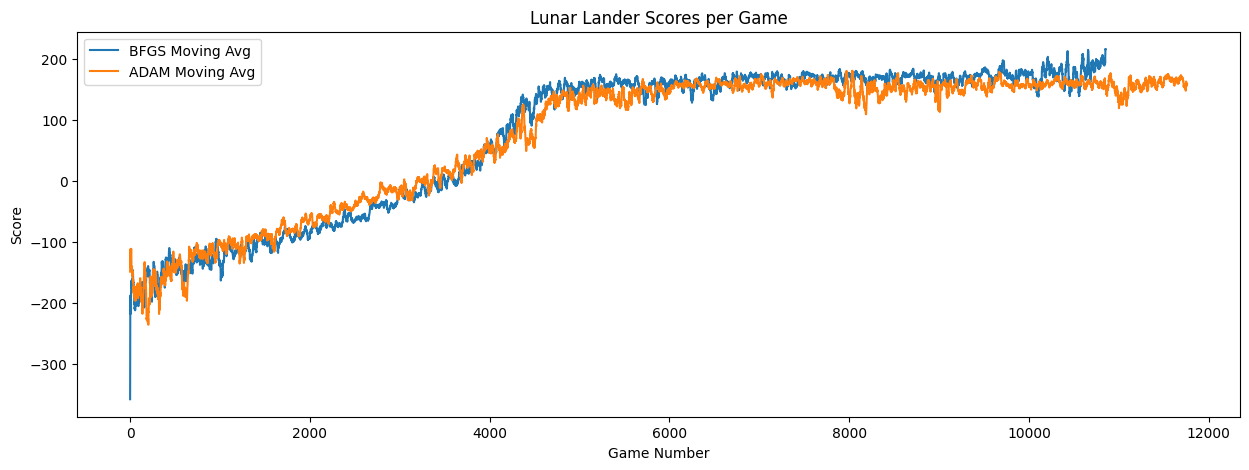

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(bfgs_log["running_avg_scores"], label="BFGS Moving Avg")
plt.plot(adam_log["running_avg_scores"], label="ADAM Moving Avg")
plt.title("Lunar Lander Scores per Game")
plt.xlabel("Game Number")
plt.ylabel("Score")
plt.legend()
plt.show()

Looks like it works! Its cool to see our Adam Optimizer is pretty close to the BFGS implementation, but BFGS just seems to barely beat ADAM. This could probably be better with more hyperparameter optimization (things like adding an LR scheduler or something) but for now as a test case this is fine!

### Lets Play a Game!

In [14]:
from IPython.display import Video
def record_game(env, policy, prefix, device="cpu"):

    env = gym.wrappers.RecordVideo(env, 
                                   video_folder="./savevideos", 
                                   video_length=0, 
                                   disable_logger=True,
                                   name_prefix=prefix)

    done = False
    state, _ = env.reset()
    
    while not done:

        ### Get Predicted Action ###
        action = policy(torch.tensor(state, device=device).unsqueeze(0)).argmax(axis=-1).item()

        ### Step in Environment ###
        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate 
        
        ### State is our New State ###
        state = new_state
        
    env.close()

env = gym.make("LunarLander-v3", render_mode="rgb_array")
record_game(env, bfgs_policy, prefix="policy-network")

Video("savevideos/policy-network-episode-0.mp4", embed=True)

/home/priyam/anaconda3/envs/torch/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /mnt/analysisdrive/analysis/NCSA_HAL_Tutorials/PyTorch for Reinforcement Learning/Deep RL Policy Models/Proximal Policy Optimization/savevideos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


### This Seems a Little Ridiculous

If you got this far congrats! But as you can imagine, this is a crazy way to do the constrained optimization problem. There is just way to much going on, and every step is super expensive. There must be a better way, and there is. This is we will next look at Proximal Policy Optimization! It basically just replaces all of this stuff with a simple clipping function.